In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.optimize import linear_sum_assignment
%matplotlib inline

In [20]:
imgF = cv2.imread("cloth/uTest_F.jpg")
maskF = cv2.imread("cloth-mask/uTest_mask_F.png")
imgB = cv2.imread("cloth/uTest_B.jpg")
maskB = cv2.imread("cloth-mask/uTest_mask_B.png")

In [5]:
def imshow(img):
    plt.axis('off')
    if len(img.shape) == 3:
        img = img[:,:,::-1]
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

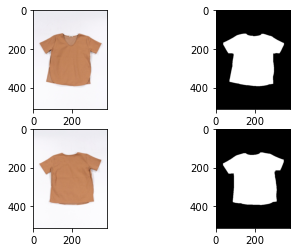

In [25]:
plt.subplot(2, 2, 1)
plt.imshow(imgF[:,:,::-1])
plt.subplot(2, 2, 2)
plt.imshow(maskF[:,:,::-1])
plt.subplot(2, 2, 3)
plt.imshow(imgB[:,:,::-1])
plt.subplot(2, 2, 4)
plt.imshow(maskB[:,:,::-1])
plt.show()

In [23]:
#flip
def flip(img):
    img_flip_lr = cv2.flip(img, 1)
    return img_flip_lr

In [24]:
imgB = flip(imgB)
maskB = flip(maskB)

In [28]:
def Edge_detection(img, kernel_size = (3, 3), thresh1 = 50, thresh2 = 150):
    """
    1. using gaussian blur
    2. using canny athgorthm
    """
    img = cv2.GaussianBlur(img, kernel_size, 0)
    canny = cv2.Canny(img, thresh1, thresh2)
    return canny

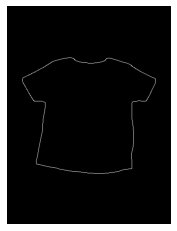

In [30]:
mask_F = Edge_detection(maskF)
imshow(mask_F)

In [31]:
#jitendra 
def Jitendra_Sample(points, N = 100, k = 3):
    """
    Jitendra's sampling
    points: sample, shape[I, 2], I:
    N: sample
    k: thresh
    """
    # points sample
    I = points.shape[0]
    #xáo trộn điểm mẫu
    points = np.random.permutation(points)
    
    NStart = min(k*N, I)
    #thresh
    if I > k * N:
        NStart_sample_points = points[:NStart]
        
    #matrix by dis Euclide
    dist = np.sqrt(np.sum(np.square(NStart_sample_points.reshape((1,NStart,2)) - NStart_sample_points.reshape((NStart,1,2))), axis=-1)) + np.eye(NStart, dtype=int) * 999999999999
    
    #loop remove to N point
    for num in range(NStart - N):
        #remove point
        #i = np.where(dist == np.min(dist))[0][0]
        j = np.where(dist == np.min(dist))[1][0]
        dist[j, :] = 999999999999; dist[:, j] = 999999999999
     
    #no overlap
    i = np.unique(np.where(dist < 999999999999)[0])
    sample_points = NStart_sample_points[i]
    return sample_points

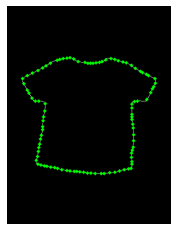

In [34]:
#find contour
points = np.array([np.where(mask_F==255)[0], np.where(mask_F==255)[1]]).T
sample_points = Jitendra_Sample(points, N=100, k=3)

mask_F1 = cv2.cvtColor(mask_F, cv2.COLOR_GRAY2RGB)
for point in sample_points:
    cv2.circle(mask_F1, (point[1], point[0]), 2, [0, 255, 0], 4)
    
imshow(mask_F1)

In [37]:
points.shape

(1039, 2)

In [40]:
def Shape_Context(points, angle = 12, distance = [0,0.125,0.25, 0.5, 1.0, 2.0]):
    """
    
    """
    N = points.shape[0]
    #dist = np.sqrt(np.sum(np.square(points.reshape((1,N,2)) - points.reshape((N,1,2))), axis=-1))
    
    dist = np.sqrt(np.sum(np.square(points.reshape((1, N, 2)) - points.reshape((N, 1, 2))), axis = -1))
    
    #mean
    mean_dist = np.sum(dist) / (N*N - N)
    #
    dist = np.log(dist/mean_dist+0.000000000001) + np.eye(N, dtype = int)* 999
    # print(dist)
    
    #theta
    theta = np.arctan((points[:,1].reshape(1,N)-points[:,1].reshape(N,1))/(points[:,0].reshape(1,N)-points[:,0].reshape(N,1)+0.000000000001))/math.pi + ((points[:,0].reshape(1,N)-points[:,0].reshape(N,1))<0).astype(int) + 0.5   # range(0, 2)
    
    histogram_feature = np.zeros((N, angle, len(distance)))
    
    for i in range(angle):
        #angle range
        angle_matrix = (theta > (2/angle * i)) * (theta <= (2/angle * (i+1)))
        for j in range(1, len(distance)):
            distance_matrix = (dist < distance[j]) * (dist > distance[j-1])
            histogram_feature[:,i,j-1] = np.sum(angle_matrix * distance_matrix, axis = 1)
    
    return histogram_feature
        

In [41]:
histogram_feature = Shape_Context(sample_points)

In [42]:
histogram_feature

array([[[ 3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ...,
        [ 0.,  1., 15.,  0.,  0.,  0.],
        [ 0.,  0., 10., 10.,  0.,  0.],
        [ 0., 10.,  1.,  0.,  0.,  0.]],

       [[ 0., 11.,  4.,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  6.,  3.,  0.,  0.,  0.],
        [ 0.,  5.,  9.,  0.,  0.,  0.]],

       [[ 3.,  9.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ...,
        [10.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  3., 12.,  0.,  0.,  0.],
        [ 0.,  8.,  7.,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        ...,
        [ 2.,  5.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [

In [43]:
def visualization(img_path, sample_points, index):
    for i in range(len(index)):
        img = cv2.imread(img_path)
        img = Edge_detection(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        for point in sample_points:
            cv2.circle(img, (point[1], point[0]), 2, [0, 255, 0], 4)
        cv2.circle(img, (sample_points[i][1], sample_points[i][0]), 4, [255,0,0], 6)
        plt.subplot(2, len(index), i+1)
        plt.axis('off')
        plt.imshow(img)
        
        plt.subplot(2, len(index), i+1+len(index))
        plt.axis('off')
        plt.imshow(histogram_feature[index[i]].astype(np.uint8))
        
    plt.show()

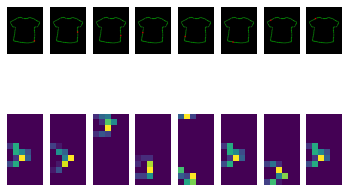

In [44]:
visualization("cloth-mask/uTest_mask_F.png", sample_points, index = [12, 74, 42, 23, 63, 12, 53, 12])

In [54]:
def Cost_function_Shape_Context(histogram1, histogram2):
    """
    cost matrix
    histogram1: N1xAxD
    histogram2: N2xAxD
    """
    A = histogram1.shape[1]
    D = histogram2.shape[2]
    N1 = histogram1.shape[0]
    N2 = histogram2.shape[0]
    assert histogram1.shape[1] == histogram2.shape[1]
    assert histogram1.shape[2] == histogram2.shape[2]
    
    cost = 0.5 * np.sum(np.sum(np.square(
            histogram1.reshape((N1,1,A,D)) - histogram2.reshape((1,N2,A,D))) / (histogram1.reshape((N1,1,A,D)) + histogram2.reshape((1,N2,A,D))+0.000000001)
        ,axis=-1),axis=-1)
    return cost

In [55]:
def Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2):
    """
    Local Appearance
    """
    N1 = sample_points1.shape[0]
    N2 = sample_points2.shape[0]

    img1gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    sobel1_x = cv2.Sobel(img1gray,cv2.CV_64F,1,0,ksize=3)
    sobel1_y = cv2.Sobel(img1gray,cv2.CV_64F,0,1,ksize=3)

    sobel2_x = cv2.Sobel(img2gray,cv2.CV_64F,1,0,ksize=3)
    sobel2_y = cv2.Sobel(img2gray,cv2.CV_64F,0,1,ksize=3)
    
    cos1 = sobel1_x[sample_points1[:,0],sample_points1[:,1]]
    cos2 = sobel2_x[sample_points2[:,0],sample_points2[:,1]]
    sin1 = sobel1_y[sample_points1[:,0],sample_points1[:,1]]
    sin2 = sobel2_y[sample_points2[:,0],sample_points2[:,1]]

    cost = 0.5 * np.sqrt(
         np.square(cos2.reshape(1,N2) - cos1.reshape(N1,1)) + np.square(sin2.reshape(1,N2) - sin1.reshape(N1,1))
    )
    return cost

(100, 2)
(100, 2)


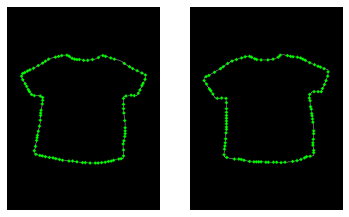

In [56]:
N = 100
angle = 12

img1 = cv2.imread("cloth-mask/uTest_mask_F.png")
im = Edge_detection(img1)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points1 = Jitendra_Sample(points, N=N, k=3)
print(sample_points1.shape)
# contour
img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
for point in sample_points1:
	cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)
histogram_feature1 = Shape_Context(sample_points1, angle)

img2 = cv2.imread("cloth-mask/uTest_mask_B.png")
#flip
img2 = flip(img2)
im = Edge_detection(img2)
points = np.array([np.where(im==255)[0],np.where(im==255)[1]]).T
sample_points2 = Jitendra_Sample(points, N=100, k=3)
print(sample_points2.shape)
# contour
img = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
for point in sample_points2:
	cv2.circle(img, (point[1],point[0]), 2, [0,255,0],4)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img)
histogram_feature2 = Shape_Context(sample_points2, angle)



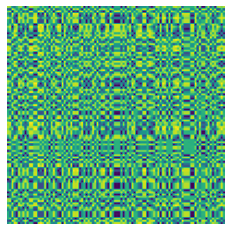

In [57]:
cost_matrix = Cost_function_Shape_Context(histogram_feature1, histogram_feature2) + Cost_function_Local_Appearance(img1, img2, sample_points1, sample_points2)
plt.axis('off')
plt.imshow(cost_matrix)

In [58]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)
match = np.array([[x,y] for x,y in zip(row_ind,col_ind)])

In [62]:
def drawmatch(img_path1, img_path2, points1, points2, match, visual_num=20):
    """
    img_path1: path img1
    img_path2: path img2
    points1: coordinate img1 (N1,2)
    points2: coordinate img2 (N2,2)
    match: matching  (N3,2)
    visual_num: 
    """
    img1 = cv2.imread(img_path1); img2 = cv2.imread(img_path2)
    img2 = flip(img2)

    # match point img2 and img1
    img2 = cv2.resize(img2, (int(img1.shape[0]/img2.shape[0]*img2.shape[1]), img1.shape[0]))
    points2 = points2 * img1.shape[0] / img2.shape[0]
    points2[:, 1] +=  img1.shape[1]
    points2 = points2.astype(np.int32)

    # match image
    new_img = np.zeros([img1.shape[0], img1.shape[1]+img2.shape[1], 3])
    new_img[:,:img1.shape[1]] = img1
    new_img[:,img1.shape[1]:] = img2

    # 
    match = np.random.permutation(match)
    for i in range(visual_num):
        # random color
        color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        new_img = cv2.circle(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)
        new_img = cv2.circle(new_img, (points2[match[i][1]][1], points2[match[i][1]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)

        new_img = cv2.line(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), (points2[match[i][1]][1], points2[match[i][1]][0]), color, 1)

    new_img = new_img.astype(np.uint8)

    imshow(new_img)

In [60]:
def drawmatch_(img1, img2, points1, points2, match, visual_num=20):
    """

    """
    new_img = np.zeros([img1.shape[0], img1.shape[1]+img2.shape[1], 3])
    new_img[:,:img1.shape[1]] = img1
    new_img[:,img1.shape[1]:] = img2

    points2[:, 1] +=  img1.shape[1]
    points2 = points2.astype(np.int32)

    match = np.random.permutation(match)
    for i in range(visual_num):

        color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        new_img = cv2.circle(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)
        new_img = cv2.circle(new_img, (points2[match[i][1]][1], points2[match[i][1]][0]), int(img1.shape[0]/100), color, int(img1.shape[0]/200), 8, 0)

        new_img = cv2.line(new_img, (points1[match[i][0]][1], points1[match[i][0]][0]), (points2[match[i][1]][1], points2[match[i][1]][0]), color, 1)

    new_img = new_img.astype(np.uint8)

    imshow(new_img)
    cv2.imwrite("result.jpg", new_img)

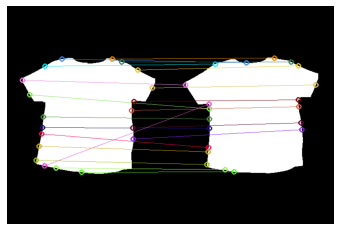

In [63]:
drawmatch(img_path1="cloth-mask/uTest_mask_F.png", img_path2="cloth-mask/uTest_mask_B.png", points1 = sample_points1, points2 = sample_points2, match = match, visual_num=20)